In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
COVID_IMG = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
NORMAL_IMG = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
VIRAL_PNEUMONIA_IMG = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

os.makedirs('./COVID19-DATASET/train/covid19', exist_ok=True)
os.makedirs('./COVID19-DATASET/train/normal', exist_ok=True)
os.makedirs('./COVID19-DATASET/test/covid19', exist_ok=True)
os.makedirs('./COVID19-DATASET/test/normal', exist_ok=True)
os.makedirs('./COVID19-DATASET/train/viral_pneumonia', exist_ok=True)
os.makedirs('./COVID19-DATASET/test/viral_pneumonia', exist_ok=True)

In [3]:
covid_images = [os.path.join(COVID_IMG, image) for image in os.listdir(COVID_IMG)]
normal_images = [os.path.join(NORMAL_IMG, image) for image in os.listdir(NORMAL_IMG)]
viral_pneumonia_images = [os.path.join(VIRAL_PNEUMONIA_IMG, image) for image in os.listdir(VIRAL_PNEUMONIA_IMG)]


covid_train, covid_test = train_test_split(covid_images, test_size=0.2, random_state=42)
normal_train, normal_test = train_test_split(normal_images, test_size=0.2, random_state=42)
viral_pneumonia_train, viral_pneumonia_test = train_test_split(viral_pneumonia_images, test_size=0.2, random_state=42)

In [4]:
for image in covid_train:
    shutil.copy(image, os.path.join('./COVID19-DATASET/train/covid19', os.path.basename(image)))

for image in normal_train[:3000]:
    shutil.copy(image, os.path.join('./COVID19-DATASET/train/normal', os.path.basename(image)))
    
for image in viral_pneumonia_train:
    shutil.copy(image, os.path.join('./COVID19-DATASET/train/viral_pneumonia', os.path.basename(image)))

for image in viral_pneumonia_test:
    shutil.copy(image, os.path.join('./COVID19-DATASET/test/viral_pneumonia', os.path.basename(image)))

In [5]:
for image in covid_test:
    shutil.copy(image, os.path.join('./COVID19-DATASET/test/covid19', os.path.basename(image)))

for image in normal_test:
    shutil.copy(image, os.path.join('./COVID19-DATASET/test/normal', os.path.basename(image)))

In [6]:
DATA_PATH = './COVID19-DATASET/train'
COVID_PATH= './COVID19-DATASET/train/covid19'
NORMAL_PATH='./COVID19-DATASET/train/normal'
VIRAL_PNEUMONIA_PATH = './COVID19-DATASET/train/viral_pneumonia'

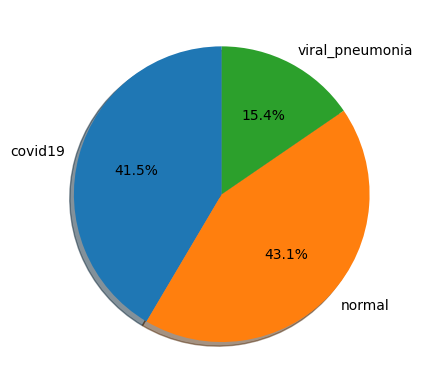

In [7]:
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

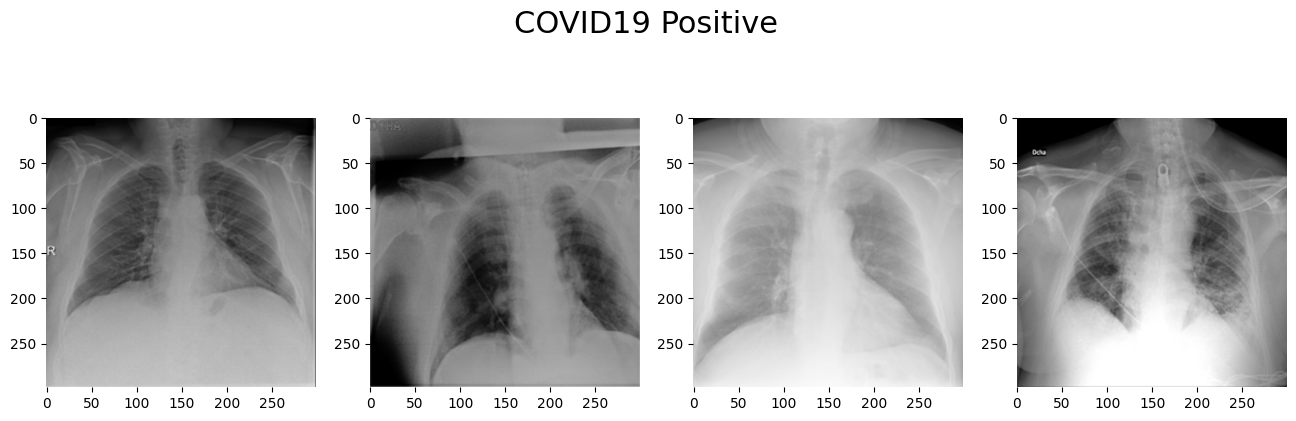

In [8]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

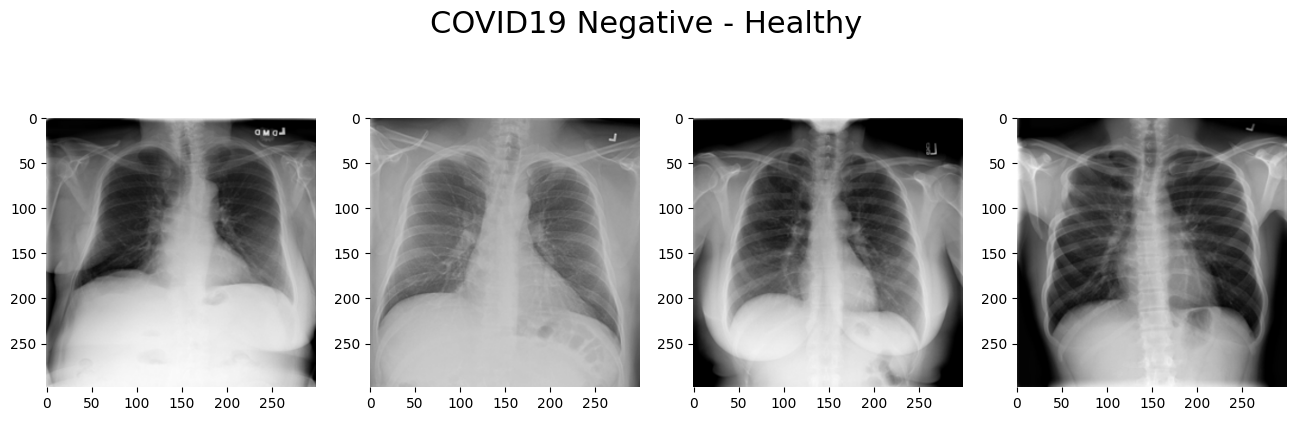

In [9]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

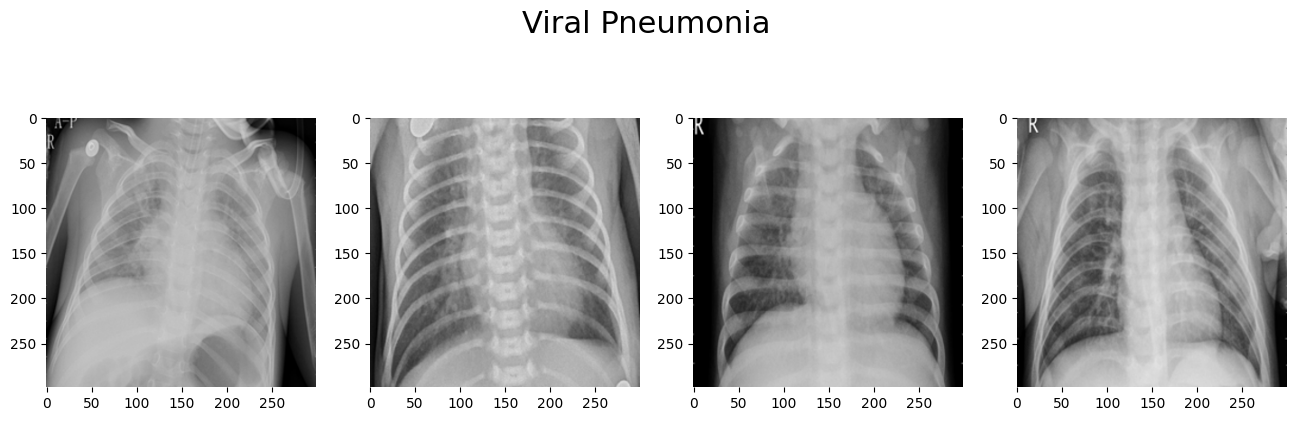

In [10]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("Viral Pneumonia", size=22)
img_paths = os.listdir(VIRAL_PNEUMONIA_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(VIRAL_PNEUMONIA_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [11]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), 
                                transforms.RandomRotation(10), 
                                transforms.RandomHorizontalFlip(p=0.4), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), 
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [12]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=16) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=16)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['covid19', 'normal', 'viral_pneumonia']


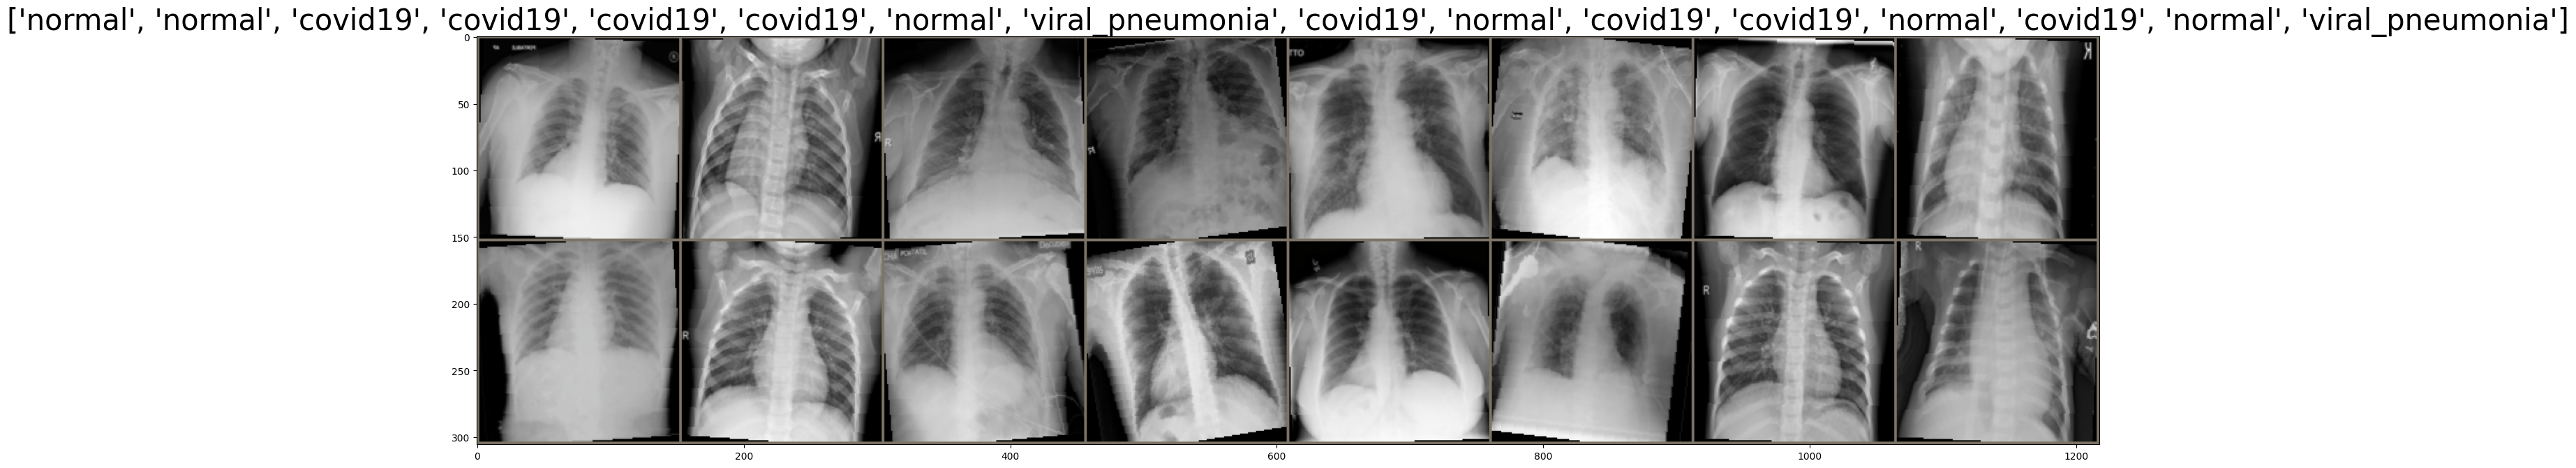

In [13]:
def imshow(inp, size =(30,30), title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

Training on GPU


In [15]:
torch.cuda.empty_cache()

In [16]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) 
    num_ftrs = model.classifier.in_features 
    model.classifier = nn.Linear(num_ftrs, len(class_names)) 
    model = model.to(device) 
    return model

model = CNN_Model(pretrained=True)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.95) 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 85.9MB/s]


In [17]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6956931


In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)


Epoch 1/20
----------


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.3289 | train Accuracy: 0.8725


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1818 | val Accuracy: 0.9411 | Kappa Score: nan
Val loss Decreased from inf to 0.1818 
Saving Weights... 

Epoch 2/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1882 | train Accuracy: 0.9343


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1760 | val Accuracy: 0.9433 | Kappa Score: nan
Val loss Decreased from 0.1818 to 0.1760 
Saving Weights... 

Epoch 3/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1809 | train Accuracy: 0.9378


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1650 | val Accuracy: 0.9469 | Kappa Score: nan
Val loss Decreased from 0.1760 to 0.1650 
Saving Weights... 

Epoch 4/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1753 | train Accuracy: 0.9413


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1654 | val Accuracy: 0.9483 | Kappa Score: nan

Epoch 5/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1881 | train Accuracy: 0.9358


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1751 | val Accuracy: 0.9440 | Kappa Score: nan

Epoch 6/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1788 | train Accuracy: 0.9415


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1725 | val Accuracy: 0.9419 | Kappa Score: nan

Epoch 7/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1809 | train Accuracy: 0.9363


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1710 | val Accuracy: 0.9454 | Kappa Score: nan

Epoch 8/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1778 | train Accuracy: 0.9392


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1645 | val Accuracy: 0.9447 | Kappa Score: nan
Val loss Decreased from 0.1650 to 0.1645 
Saving Weights... 

Epoch 9/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1757 | train Accuracy: 0.9410


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1644 | val Accuracy: 0.9454 | Kappa Score: nan
Val loss Decreased from 0.1645 to 0.1644 
Saving Weights... 

Epoch 10/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1850 | train Accuracy: 0.9324


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1661 | val Accuracy: 0.9462 | Kappa Score: nan

Epoch 11/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1794 | train Accuracy: 0.9363


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1632 | val Accuracy: 0.9462 | Kappa Score: nan
Val loss Decreased from 0.1644 to 0.1632 
Saving Weights... 

Epoch 12/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1815 | train Accuracy: 0.9387


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1640 | val Accuracy: 0.9462 | Kappa Score: nan

Epoch 13/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1751 | train Accuracy: 0.9421


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1736 | val Accuracy: 0.9433 | Kappa Score: nan

Epoch 14/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1756 | train Accuracy: 0.9399


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1748 | val Accuracy: 0.9490 | Kappa Score: nan

Epoch 15/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1776 | train Accuracy: 0.9376


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1640 | val Accuracy: 0.9462 | Kappa Score: nan

Epoch 16/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1891 | train Accuracy: 0.9349


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1644 | val Accuracy: 0.9476 | Kappa Score: nan

Epoch 17/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1774 | train Accuracy: 0.9392


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1700 | val Accuracy: 0.9483 | Kappa Score: nan

Epoch 18/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1815 | train Accuracy: 0.9351


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1625 | val Accuracy: 0.9469 | Kappa Score: 0.8973
Val loss Decreased from 0.1632 to 0.1625 
Saving Weights... 

Epoch 19/20
----------


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1778 | train Accuracy: 0.9392


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1647 | val Accuracy: 0.9483 | Kappa Score: nan

Epoch 20/20
----------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train:   0%|          | 0/349 [00:00<?, ?it/s]

train Loss: 0.1717 | train Accuracy: 0.9401


val:   0%|          | 0/88 [00:00<?, ?it/s]

val Loss: 0.1664 | val Accuracy: 0.9447 | Kappa Score: nan

Training complete in 16m 45s
Best val loss: 0.1625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


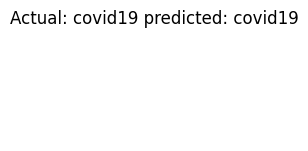

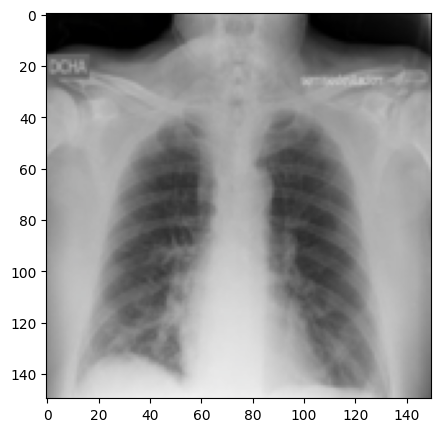

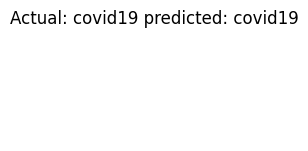

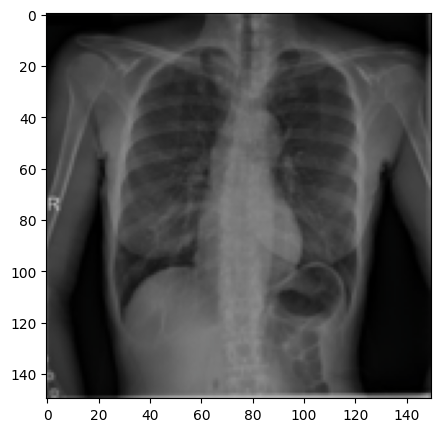

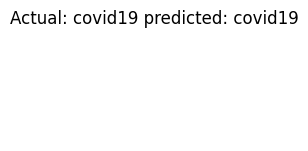

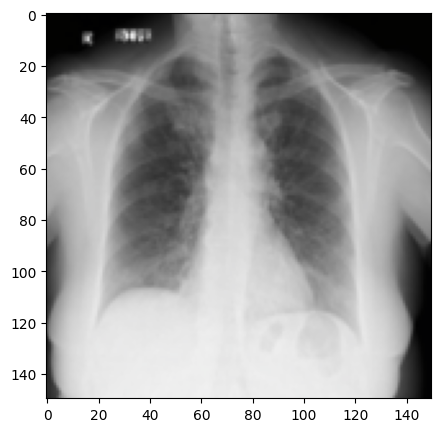

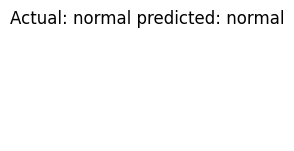

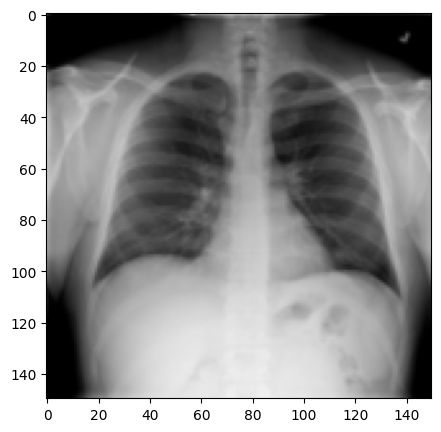

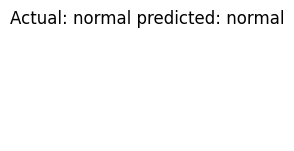

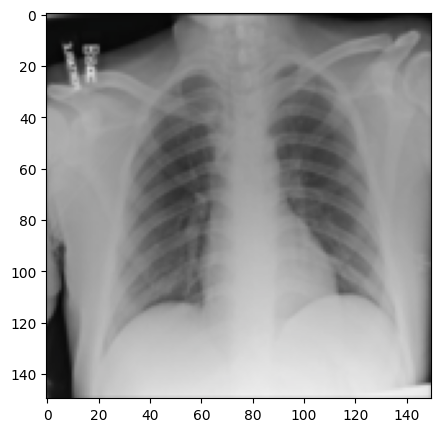

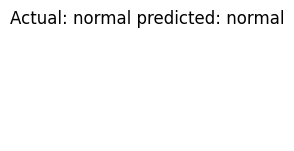

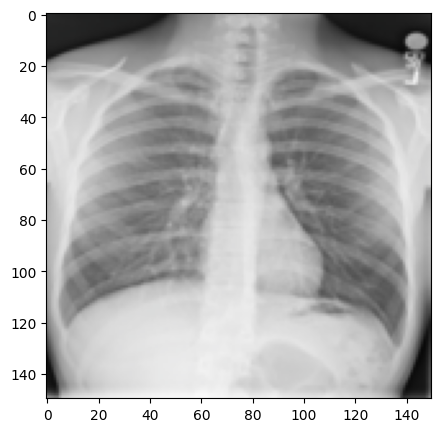

In [21]:
visualize_model(base_model)
plt.show()

In [22]:
TEST_DATA_PATH = './COVID19-DATASET/test/'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [23]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/3032 [00:00<?, ?it/s]

In [24]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [25]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       724
           1       0.97      0.95      0.96      2039
           2       0.98      0.96      0.97       269

    accuracy                           0.95      3032
   macro avg       0.94      0.95      0.94      3032
weighted avg       0.95      0.95      0.95      3032



In [26]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

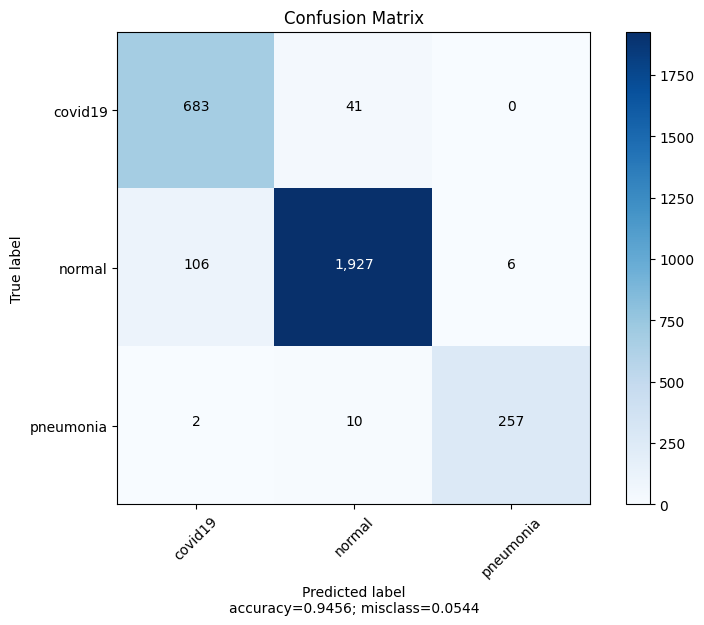

In [27]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal','pneumonia'],
                      title        = "Confusion Matrix")